In [11]:
import nipype.pipeline.engine as pe
import nipype.interfaces.io as nio
from nipype.interfaces import ants
from nipype.interfaces import fsl
from nipype.interfaces import utility as util

In [12]:
!cat /home/gdholla1/projects/bias/src/fmri_modelfits/level3.py

import nipype.pipeline.engine as pe

from nipype.interfaces import io as nio
from nipype.interfaces import ants
from nipype.interfaces import fsl
from nipype.interfaces import utility as util
from nipype.workflows.fmri.fsl.estimate import create_overlay_workflow
import numpy as np

from nipype.workflows.fmri.fsl.estimate import create_fixed_effects_flow

subject_ids = ['%02d' % i for i in np.arange(1, 20)]

templates = {'level2_cope':'/home/gdholla1/projects/bias/data/derivatives/glm_fits_level2/level2_copes/_mask_{mask}_subject_id_{subject_id}/_fwhm_5.0/_flameo{contrast}/cope1.nii.gz',
             'level2_varcope':'/home/gdholla1/projects/bias/data/derivatives/glm_fits_level2/level2_varcopes/_mask_{mask}_subject_id_{subject_id}/_fwhm_5.0/_flameo{contrast}/varcope1.nii.gz',
             'level2_tdof':'/home/gdholla1/projects/bias/data/derivatives/glm_fits_level2/level2_tdof/_mask_{mask}_subject_id_{subject_id}/_fwhm_5.0/_flameo{contrast}/tdof_t1.nii.gz',             
             'epi

In [24]:
templates = {'epi2struct':'/home/gdholla1/projects/bias/data/derivatives/registration/epi2t1weighted/epi2structmat_ants/_subject_id_{subject_id}/transformComposite.h5',
             'struct2mni':'/home/gdholla1/projects/bias/data/derivatives/registration/epi2t1weighted/struct2mnimat_ants/_subject_id_{subject_id}/transformComposite.h5',
             'tsnr':'/home/gdholla1/projects/bias/data/processed/feat_preprocess/tsnr/_subject_id_{subject_id}/_fwhm_0.0/_tsnr0/tsnr.nii.gz'}

workflow = pe.Workflow(name='tsnr2mni')
workflow.base_dir = '/home/gdholla1/projects/bias/workflow_folders/'

selector = pe.MapNode(nio.SelectFiles(templates), iterfield=['subject_id'], name='selector')
selector.inputs.subject_id = ['%02d' % i for i in xrange(1, 20)]


transformer = pe.MapNode(ants.ApplyTransforms(), iterfield=['input_image', 'transforms'], name='transformer')
transformer.inputs.reference_image = fsl.Info.standard_image('MNI152_T1_1mm.nii.gz')

merger = pe.MapNode(util.Merge(2), iterfield=['in1', 'in2'], nested=True, name='transform_merger')

workflow.connect(selector, 'struct2mni', merger, 'in1')
workflow.connect(selector, 'epi2struct', merger, 'in2')
workflow.connect(merger, 'out', transformer, 'transforms')
workflow.connect(selector, 'tsnr', transformer, 'input_image')

merger =  pe.Node(interface=fsl.Merge(dimension='t'), name="merger")
workflow.connect(transformer, 'output_image', merger, 'in_files')

meaner = pe.Node(fsl.MeanImage(dimension='T'), name='meaner')
workflow.connect(merger, 'merged_file', meaner, 'in_file')

ds = pe.Node(nio.DataSink(), name='datasink')
ds.inputs.base_directory = '/home/gdholla1/projects/bias/data/derivatives/'

workflow.connect(meaner, 'out_file', ds, 'tsnr_in_mni')
workflow.connect(transformer, 'output_image', ds, 'tsnr_in_mni.@mean')



workflow.run()

In [26]:
import nibabel as nb

In [33]:
tsnr = nb.load('/home/gdholla1/projects/bias/data/derivatives/tsnr_in_mni/tsnr_trans_merged_mean.nii.gz').get_data()

18

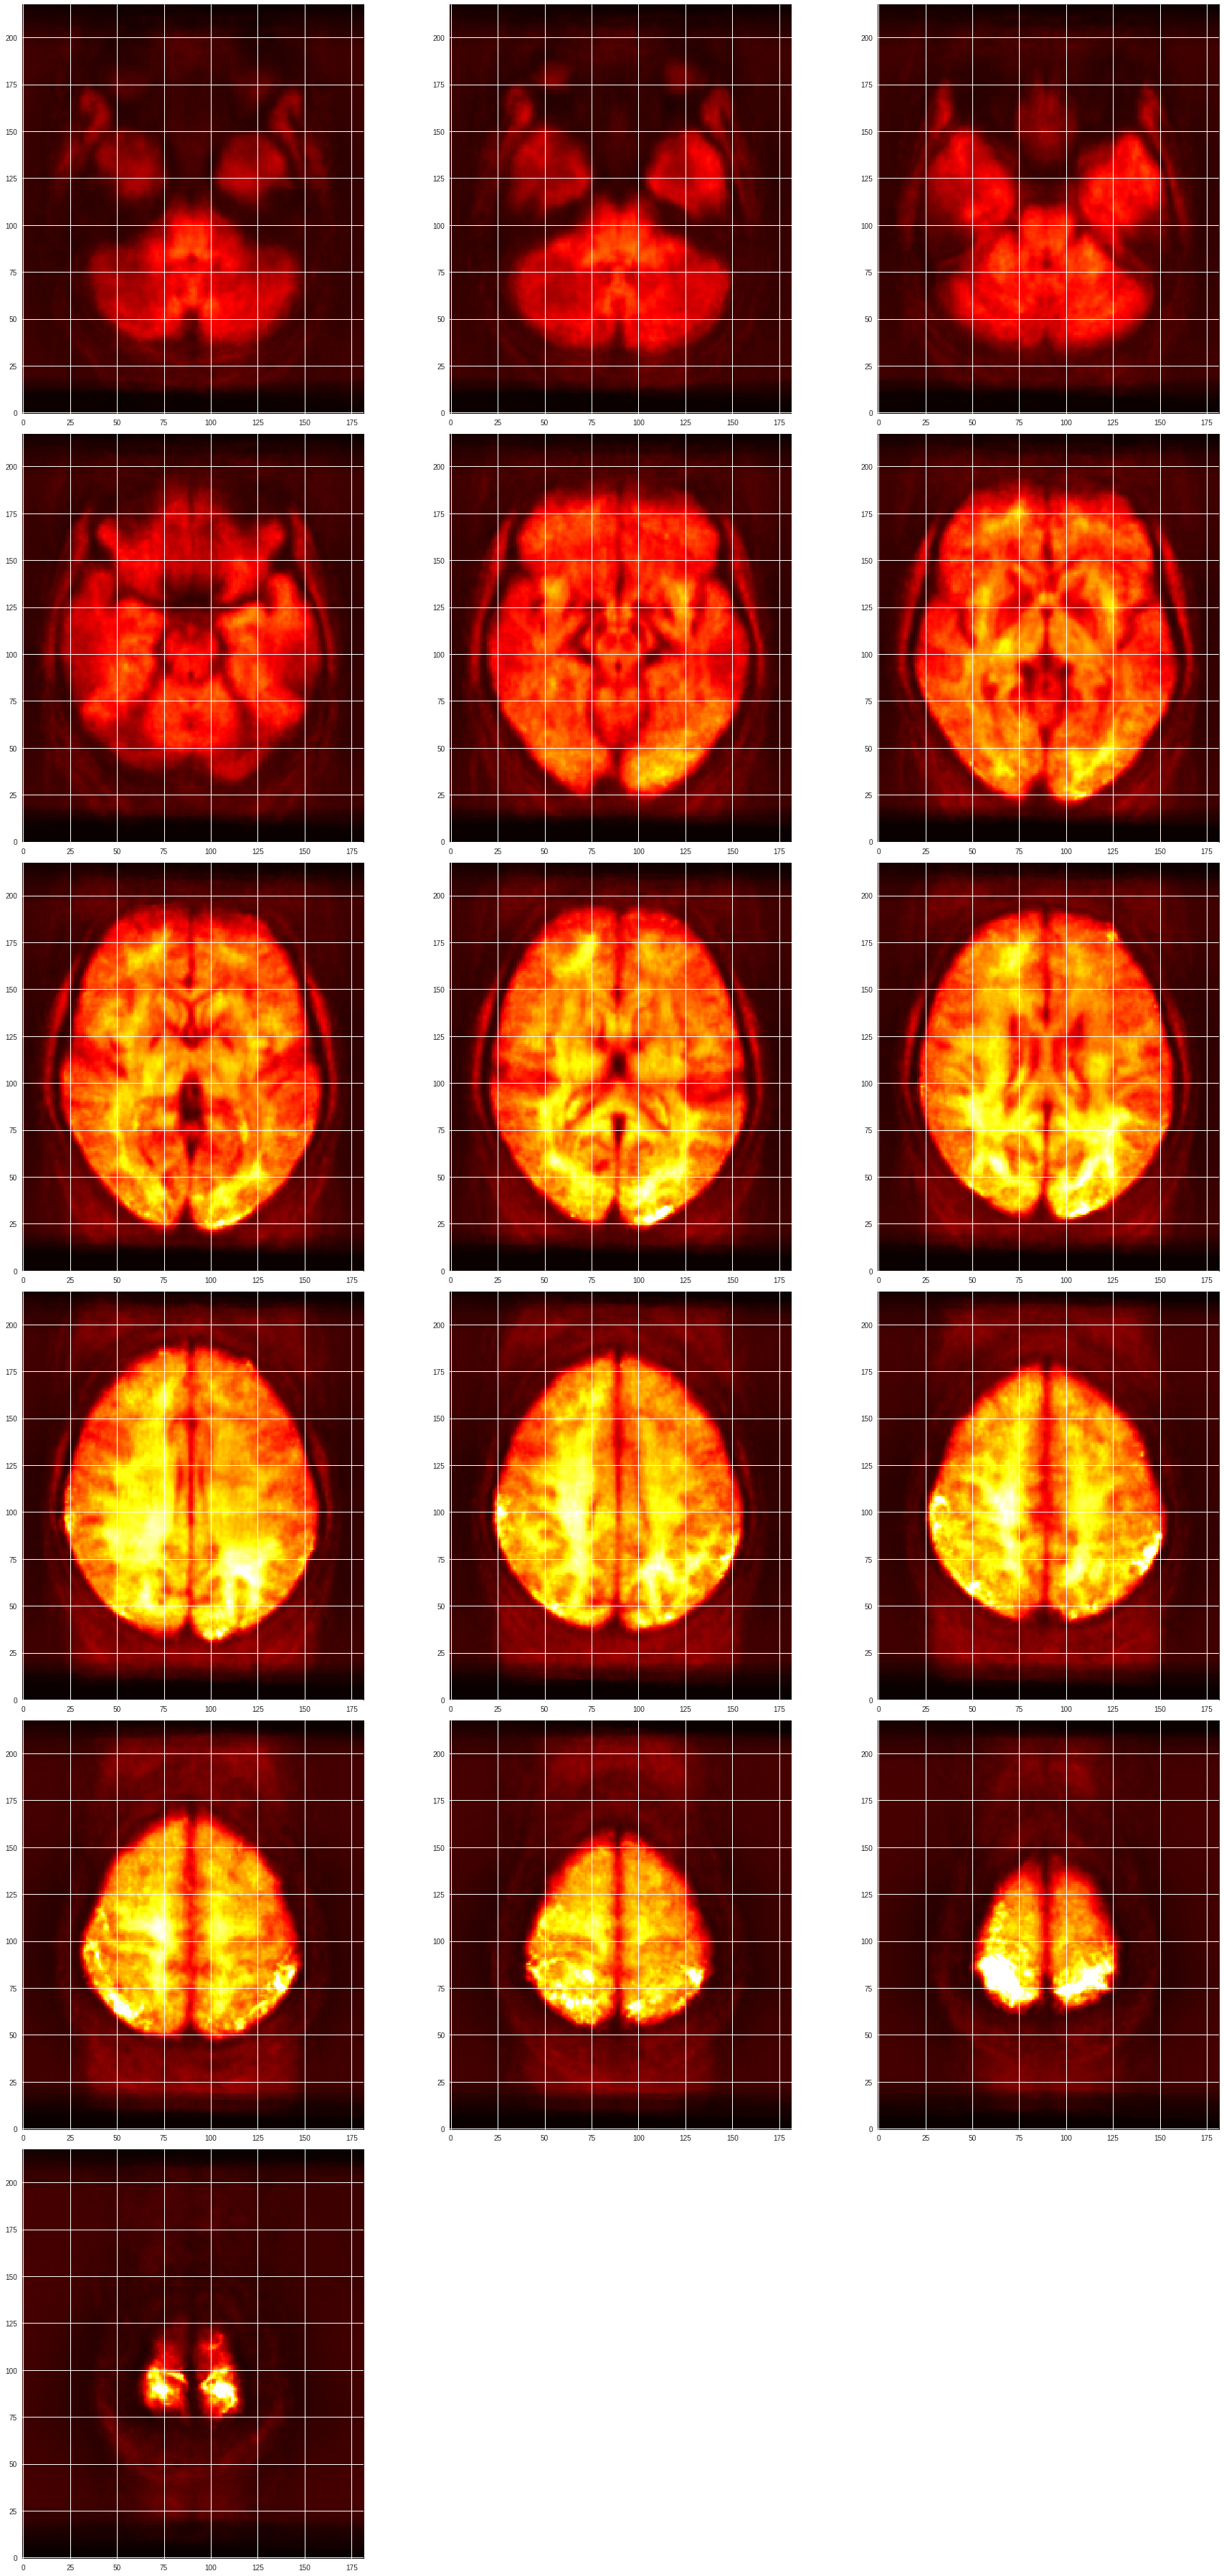

In [38]:
for i, z in enumerate(np.arange(29, 150, 8)):
    plt.subplot(6,3,i+1)
    plt.imshow(tsnr[...,z].T, origin='lower', cmap=plt.cm.hot, vmin=0, vmax=100)
    
plt.gcf().set_size_inches(25, 50)
plt.tight_layout()
